In [15]:
import torch
import os
import shutil
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [16]:
from torchvision.datasets import ImageFolder

# Data transformations for training and testing
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to match model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pretrained models
])
base_dir = 'realwaste-main/RealWaste'

train_dir = 'realwaste_data/train'
valid_dir = 'realwaste_data/valid'
test_dir = 'realwaste_data/test'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Class folders
classes = os.listdir(base_dir)

for cls in classes:
    class_path = os.path.join(base_dir, cls)
    if os.path.isdir(class_path):  # Ensure it's a directory
        images = os.listdir(class_path)
        
        # Split into train, valid, and test (70%, 20%, 10%)
        train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
        valid_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.33, random_state=42)  # 0.33 * 0.3 ≈ 0.1

        # Create class subdirectories
        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(valid_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

        # Move files
        for img in train_imgs:
            shutil.move(os.path.join(class_path, img), os.path.join(train_dir, cls, img))
        for img in valid_imgs:
            shutil.move(os.path.join(class_path, img), os.path.join(valid_dir, cls, img))
        for img in test_imgs:
            shutil.move(os.path.join(class_path, img), os.path.join(test_dir, cls, img))

print("Dataset split into train, valid, and test sets.")
# Load datasets
train_dataset = ImageFolder(train_dir, transform=transform)
valid_dataset = ImageFolder(valid_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Number of classes
num_classes = len(train_dataset.classes)


Dataset split into train, valid, and test sets.


In [17]:
from torchvision.datasets import ImageFolder

# Data transformations for training and testing
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to match model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pretrained models
])

# Load datasets
train_dataset = ImageFolder(train_dir, transform=transform)
valid_dataset = ImageFolder(valid_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Number of classes
num_classes = len(train_dataset.classes)


In [18]:
# Function to fine-tune a model
def fine_tune_model(pretrained_model, num_classes):
    # Modify the final layer
    for param in pretrained_model.parameters():
        param.requires_grad = False  # Freeze all layers except the final layer
    
    # Replace the classifier layer to match the number of classes
    if isinstance(pretrained_model, models.ResNet):
        pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, num_classes)
    elif isinstance(pretrained_model, models.GoogLeNet):
        pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, num_classes)
    
    return pretrained_model.to(device)

# Load ResNet and GoogLeNet models
resnet_model = fine_tune_model(models.resnet18(pretrained=True), num_classes)
googlenet_model = fine_tune_model(models.googlenet(pretrained=True), num_classes)


c:\Users\senum\OneDrive\Documents\binary_deepfake_detection\.conda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\senum\OneDrive\Documents\binary_deepfake_detection\.conda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\senum/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [05:27<00:00, 143kB/s] 
c:\Users\senum\OneDrive\Documents\binary_deepfake_detection\.conda\Lib\site-packages\torchvi

In [28]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()


In [29]:
def train_model(model, train_loader, valid_loader, epochs, optimizer):
    train_loss_hist = []
    valid_loss_hist = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_loss_hist.append(train_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
        
        valid_loss = running_loss / len(valid_loader)
        valid_loss_hist.append(valid_loss)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")
    
    # Return the loss history
    return train_loss_hist, valid_loss_hist


In [ ]:
# Train ResNet
print("\nTraining ResNet:")
resnet_train_loss, resnet_valid_loss = train_model(resnet_model, train_loader, valid_loader, epochs=20, optimizer=resnet_optimizer)

# Train GoogLeNet
# print("\nTraining GoogLeNet:")
# googlenet_train_loss, googlenet_valid_loss = train_model(googlenet_model, train_loader, valid_loader, epochs=20, optimizer=googlenet_optimizer)



Training VGG:


NameError: name 'train_model' is not defined

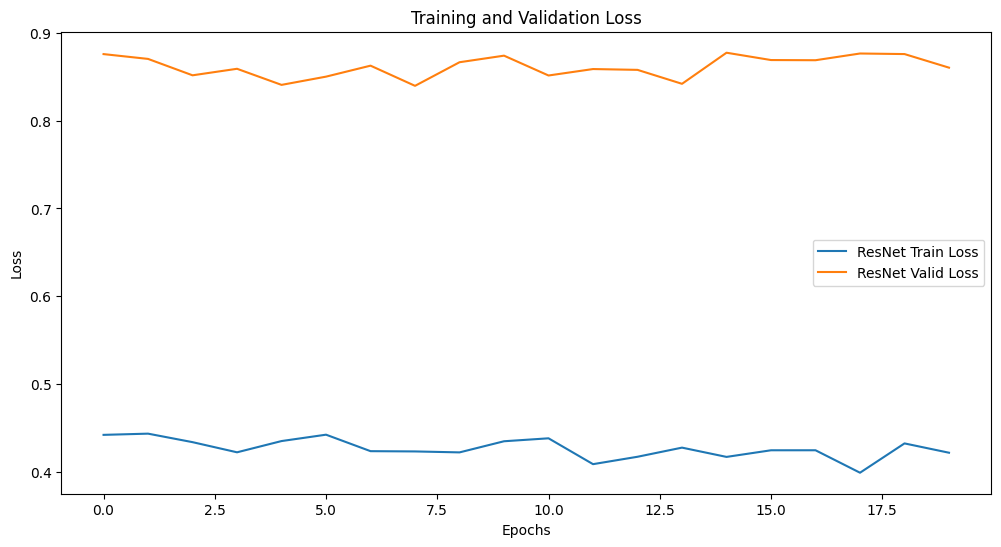

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(resnet_train_loss, label="ResNet Train Loss")
plt.plot(resnet_valid_loss, label="ResNet Valid Loss")
#plt.plot(googlenet_train_loss, label="GoogLeNet Train Loss")
#plt.plot(googlenet_valid_loss, label="GoogLeNet Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


In [33]:
# Evaluate model accuracy
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

resnet_test_accuracy = evaluate_model(resnet_model, test_loader)
#googlenet_test_accuracy = evaluate_model(googlenet_model, test_loader)

print(f"ResNet Test Accuracy: {resnet_test_accuracy:.2f}%")
#print(f"GoogLeNet Test Accuracy: {googlenet_test_accuracy:.2f}%")


ResNet Test Accuracy: 71.85%
